In [2]:
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.collections as PatchCollection
import matplotlib.patches as mpatches
import pickle
import alu_dataset

from dense_net.DenseNet import DenseNet
from soft_thresholding.SoftThresholdNet import SoftThresholdNet
from L1_regularization.L1RegularizationNet import L1RegularizationNet
from dynamic_sparse_reparameterization.DynamicSparseReparameterizationNet import DynamicSparseReparameterizationNet
from magnitude_pruning.MagnitudePruning import MagnitudePruningNet

from tqdm import tqdm

from utils import load_data, load_models, MulticolorPatch, MulticolorPatchHandler, load_state_dicts, create_models, predict, divergence_detection

/Users/emilhaugstvedt/mambaforge/envs/sparse/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load data
dataset = "alu" # alu or duffing

# Load train and val data as dataloaders
train_loader, val_loader, test_loader = load_data(f"data/{dataset}")

# Load test data sets
with open("data/alu/test_data.pickle", "rb") as f:
    test_data = pickle.load(f)
    
dt = train_loader.dataset.DT

test_data = alu_dataset.Dataset_alu(test_data, dt)

y_std = test_loader.dataset.y_std
y_mean = test_loader.dataset.y_mean
x_std = test_loader.dataset.x_std
x_mean = test_loader.dataset.x_mean

In [4]:
test_set_n = 13
x_test = test_data.data[test_set_n]

#x_mean = test_loader.x_mean
#x_std = test_loader.x_std
#y_mean = test_loader.y_mean
#y_std = test_loader.y_std

t = torch.linspace(0, dt * len(x_test)/60/60, len(x_test))

In [150]:
path = "models/alu/L1_regularization/model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
models = load_models(path, n_models=10)

#path = "models/alu/L1_regularization/model"
#state_dicts = load_state_dicts(path, n_models=10)
#layers = [13, 25, 25, 25, 25, 8]
#models = []
#for state_dict in state_dicts:
#    model = torch.optim.swa_utils.AveragedModel(L1RegularizationNet(layers))
#    model.load_state_dict(state_dict)
#    models.append(model)


#path = "models/alu/L1_regularization/swa_model"
#state_dicts = load_state_dicts(path, n_models=10)
#layers = [13, 25, 25, 25, 25, 8]
#models = []
#for state_dict in state_dicts:
#    model = torch.optim.swa_utils.AveragedModel(L1RegularizationNet(layers))
#    model.load_state_dict(state_dict)
#    models.append(model)

In [151]:
# Make predictions for each model
predictions = []
for model in models:
    prediction = predict(
                model=model,
                x_test=x_test, 
                dt=dt,
                x_mean=x_mean,
                x_std=x_std,
                y_mean=y_mean,
                y_std=y_std
            )
    predictions.append(prediction.detach())

In [152]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [153]:
figsize = set_size(600, fraction=0.5)

In [154]:
figsize

(4.151100041511, 2.565520916354898)

/var/folders/f5/y5jwy7g16938953ybw9d9kpc0000gn/T/ipykernel_10224/1857483248.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


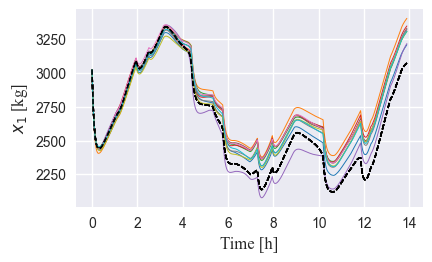

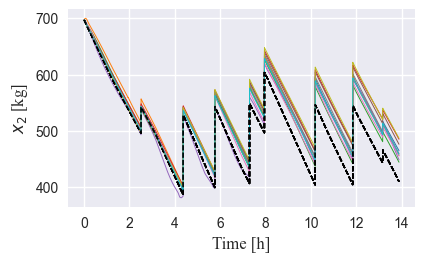

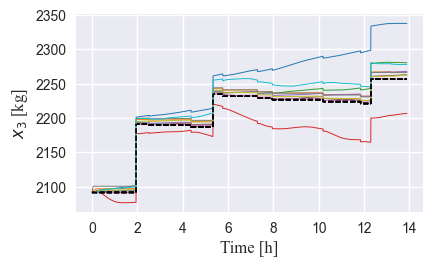

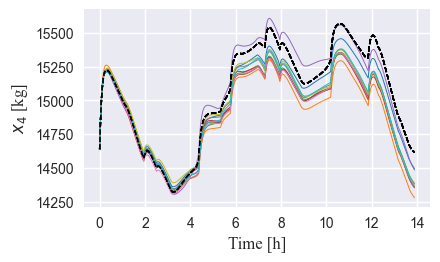

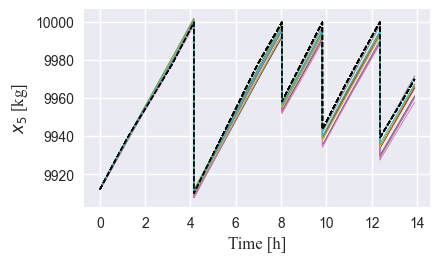

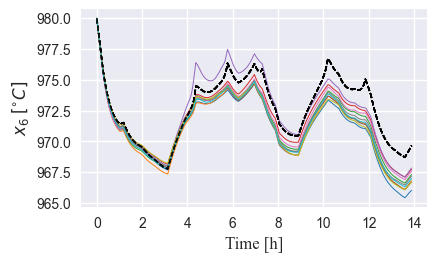

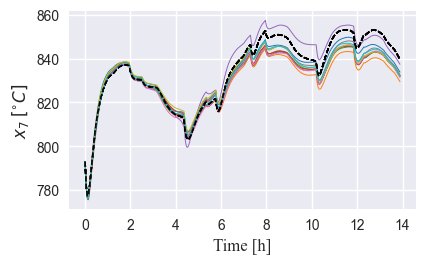

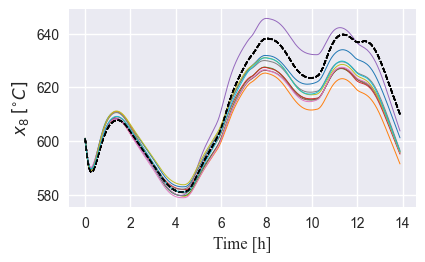

In [155]:
steps = 5000

y_labels = ["$x_1$ [kg]", "$x_2$ [kg]", "$x_3$ [kg]", "$x_4$ [kg]", "$x_5$ [kg]", "$x_6$ $[^{\circ}C]$", "$x_7$ $[^{\circ}C]$", "$x_8$ $[^{\circ}C]$"]
x_label = "Time [h]"

plt.style.use("seaborn")

# 10 matlpotlib colors
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

for s in range(8):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.tight_layout()
    #colors = []
    for p, prediction in enumerate(predictions):
        ax.plot(t[:steps], prediction[:steps, s], linewidth=0.7, color=colors[p])
        colors.append(ax.lines[-1].get_color())
        ax.plot(t[:steps], x_test[:steps, s], label="True", color="black", linestyle="--", linewidth=1)
        csfont = {'fontname':'Times New Roman'}
        fs_ax = 12
        ax.set_ylabel(y_labels[s], fontsize=fs_ax,**csfont)
        ax.set_xlabel(x_label, fontsize=fs_ax,**csfont)
        #ax[i//2, i%2].set_title(f"State {i+1}")
        #h, l = ax.get_legend_handles_labels()
        #h.append(MulticolorPatch(colors))
        #l.append("Predictions")
        #ax.legend(h, l,
        #     handler_map={MulticolorPatch: MulticolorPatchHandler()})

    plt.savefig(f"figures/L1/normal_prediction_state_{s+1}.pdf", bbox_inches="tight")

/var/folders/f5/y5jwy7g16938953ybw9d9kpc0000gn/T/ipykernel_10224/3785379644.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


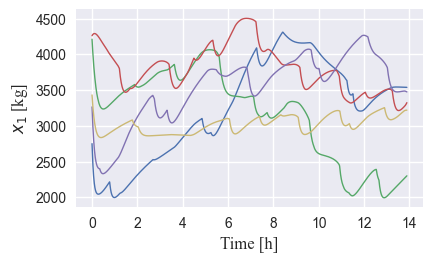

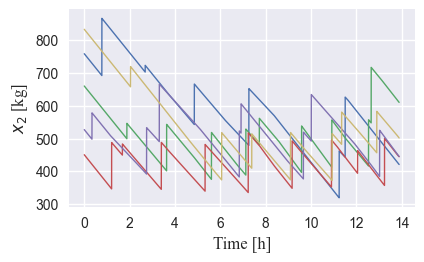

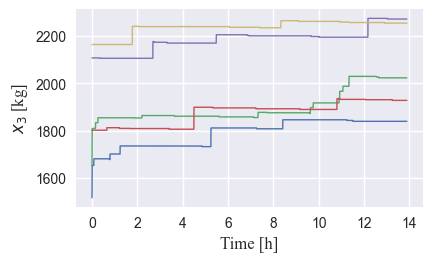

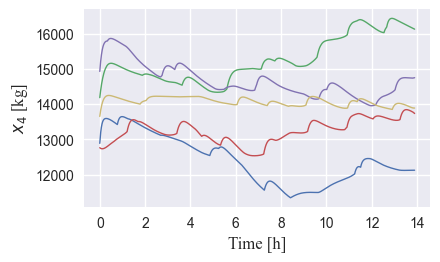

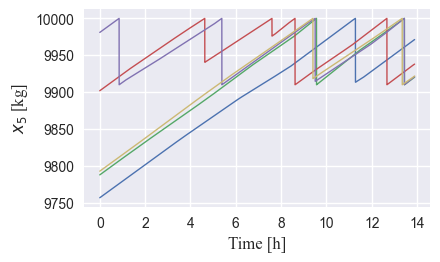

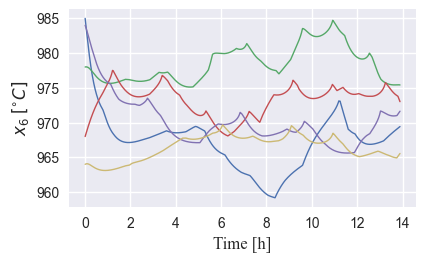

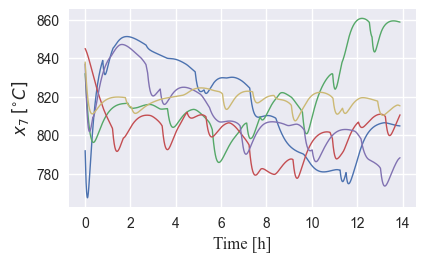

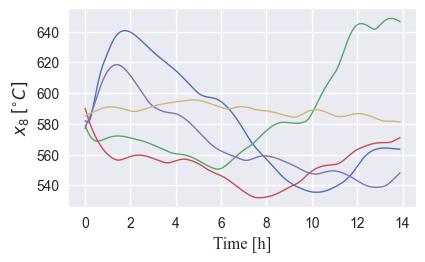

In [156]:
steps = 5000

y_labels = ["$x_1$ [kg]", "$x_2$ [kg]", "$x_3$ [kg]", "$x_4$ [kg]", "$x_5$ [kg]", "$x_6$ $[^{\circ}C]$", "$x_7$ $[^{\circ}C]$", "$x_8$ $[^{\circ}C]$"]
x_label = "Time [h]"

plt.style.use("seaborn")

# 10 matlpotlib colors
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

for s in range(8):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    plt.tight_layout()
    if (s == 3) or (s==4):
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0,5))
    #colors = []
    for sim in range(5):
        ax.plot(t[:steps], test_data.data[sim, :steps, s], label="True", linewidth=1)
        csfont = {'fontname':'Times New Roman'}
        fs_ax = 12
        ax.set_ylabel(y_labels[s], fontsize=fs_ax,**csfont)
        ax.set_xlabel(x_label, fontsize=fs_ax,**csfont)
        #ax[i//2, i%2].set_title(f"State {i+1}")
        #h, l = ax.get_legend_handles_labels()
        #h.append(MulticolorPatch(colors))
        #l.append("Predictions")
        #ax.legend(h, l,
        #     handler_map={MulticolorPatch: MulticolorPatchHandler()})

    plt.savefig(f"figures/alu/internal_states/test_{s+1}.pdf", bbox_inches="tight")

/var/folders/f5/y5jwy7g16938953ybw9d9kpc0000gn/T/ipykernel_10224/1545505995.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


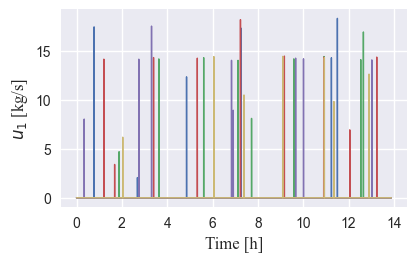

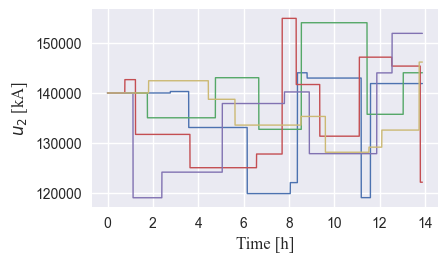

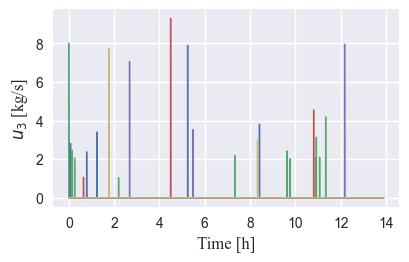

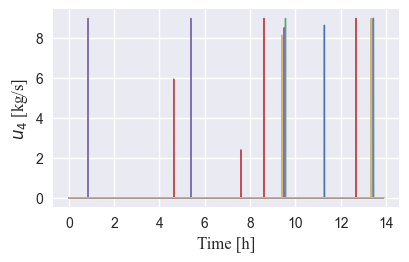

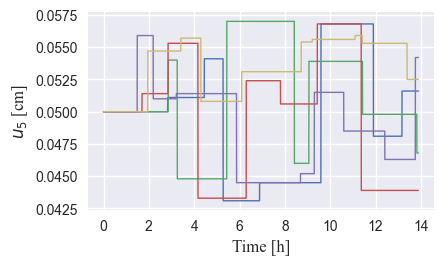

In [157]:
steps = 5000

y_labels = ["$u_1$ [kg/s]", "$u_2$ [kA]", "$u_3$ [kg/s]", "$u_4$ [kg/s]", "$u_5$ [cm]", "$x_6$ $[^{\circ}C]$", "$x_7$ $[^{\circ}C]$", "$x8$ $[^{\circ}C]$"]
x_label = "Time [h]"

plt.style.use("seaborn")

# 10 matlpotlib colors
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

data = test_data.data[:, :, 8:]

for s in range(5):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.tight_layout()
    #colors = []
    for sim in range(5):
        ax.plot(t[:steps], data[sim, :steps, s], label="True", linewidth=1)
        csfont = {'fontname':'Times New Roman'}
        fs_ax = 12
        ax.set_ylabel(y_labels[s], fontsize=fs_ax,**csfont)
        ax.set_xlabel(x_label, fontsize=fs_ax,**csfont)
        #ax[i//2, i%2].set_title(f"State {i+1}")
        #h, l = ax.get_legend_handles_labels()
        #h.append(MulticolorPatch(colors))
        #l.append("Predictions")
        #ax.legend(h, l,
        #     handler_map={MulticolorPatch: MulticolorPatchHandler()})

    plt.savefig(f"figures/alu/input/test_{s+1}.pdf", bbox_inches="tight")

In [7]:
mean_prediction = torch.zeros_like(x_test).detach()
for prediction in predictions:
    mean_prediction += prediction
mean_prediction /= len(predictions)

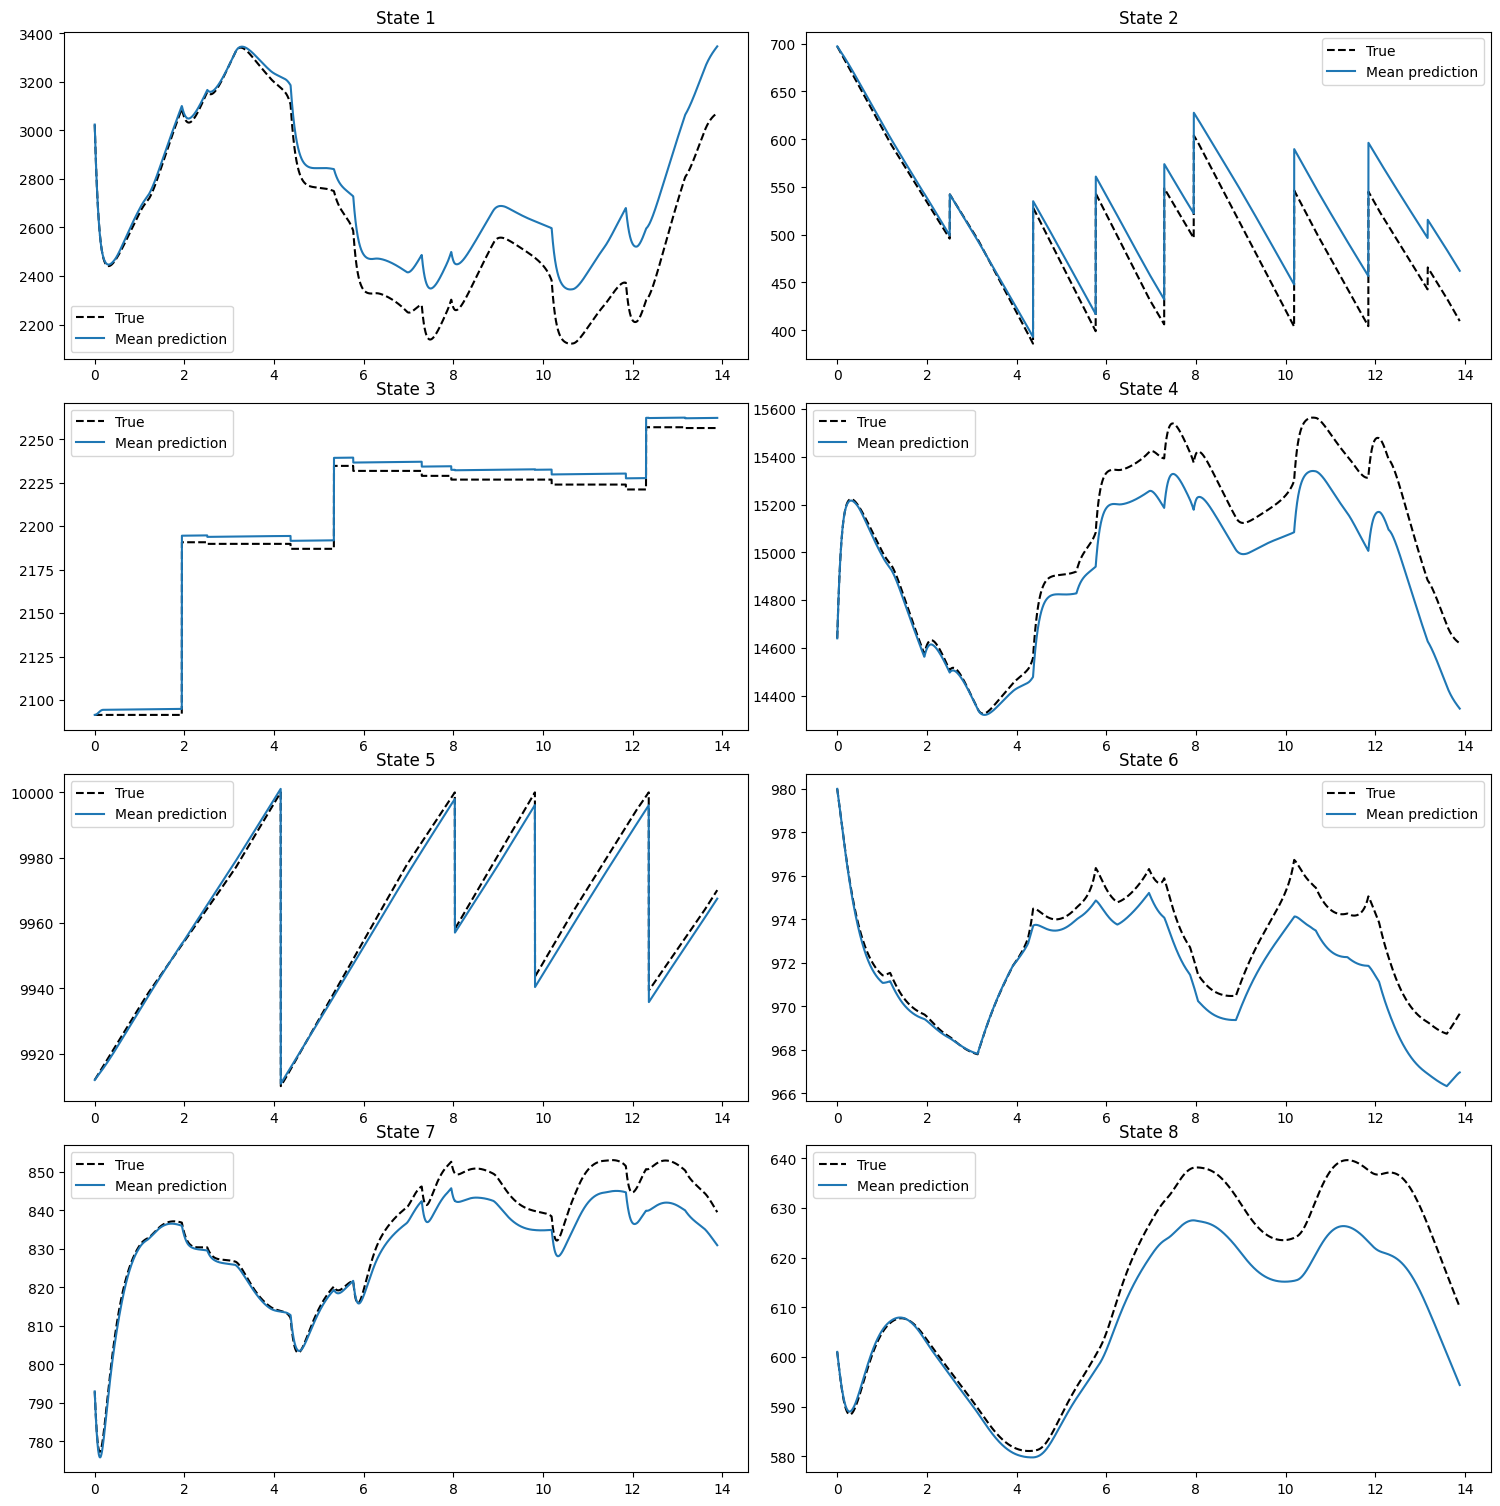

In [8]:
steps = 4999 # Max 4999

fig, ax = plt.subplots(4, 2, figsize=(15, 15))
fig.tight_layout()
for i in range(8):
    ax[i//2, i%2].plot(t[:steps], x_test[:steps, i], label="True", color="black", linestyle="--")
    ax[i//2, i%2].plot(t[:steps], mean_prediction[:steps, i].detach(), label="Mean prediction")
    ax[i//2, i%2].set_title(f"State {i+1}")
    ax[i//2, i%2].legend()

## Divergence plots for dense models

In [9]:
path = "models/alu/soft_thresholding/model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
soft_thresholding_models = load_models(path, n_models=10)

path = "models/alu/L1_regularization/model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
L1_regularization_models = load_models(path, n_models=10)

path = "models/alu/L1_regularization/best_model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
best_L1_regularization_models = load_models(path, n_models=10)

path = "models/alu/dense_net/model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
dense_models = load_models(path, n_models=10)

path = "models/alu/magnitude_pruning/model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
magnitude_pruning_models = load_models(path, n_models=10)

path = "models/alu/dynamic_sparse_reparameterization/0.5/model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
dynamic_sparse_reparameterization_models = load_models(path, n_models=10)

In [10]:
test_lengths = [100 * i for i in range(1, 51)]

In [11]:
models = soft_thresholding_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

soft_threshold_divergence_dict = divergence_dict
soft_threshold_RFMSE_dict = RFMSE_dict
print(f"Divergence for some steps: {soft_threshold_divergence_dict}")

: 

: 

In [ ]:
models = L1_regularization_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

L1_divergence_dict = divergence_dict
L1_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {L1_divergence_dict}")

Divergence dictionary for all models: {100: 0, 200: 0, 300: 1, 400: 1, 500: 2, 600: 2, 700: 2, 800: 2, 900: 2, 1000: 3, 1100: 3, 1200: 3, 1300: 3, 1400: 3, 1500: 4, 1600: 5, 1700: 6, 1800: 7, 1900: 7, 2000: 7, 2100: 7, 2200: 7, 2300: 7, 2400: 7, 2500: 7, 2600: 7, 2700: 7, 2800: 7, 2900: 7, 3000: 7, 3100: 8, 3200: 8, 3300: 8, 3400: 9, 3500: 9, 3600: 10, 3700: 11, 3800: 11, 3900: 13, 4000: 13, 4100: 14, 4200: 15, 4300: 19, 4400: 19, 4500: 20, 4600: 20, 4700: 21, 4800: 21, 4900: 22, 5000: 25}


In [ ]:
models = dynamic_sparse_reparameterization_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

DSR_divergence_dict = divergence_dict
DSR_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {DSR_divergence_dict}")

Divergence dictionary for all models: {100: 15, 200: 40, 300: 83, 400: 120, 500: 171, 600: 220, 700: 248, 800: 279, 900: 301, 1000: 318, 1100: 330, 1200: 343, 1300: 351, 1400: 355, 1500: 357, 1600: 361, 1700: 366, 1800: 368, 1900: 371, 2000: 374, 2100: 374, 2200: 375, 2300: 376, 2400: 378, 2500: 378, 2600: 381, 2700: 381, 2800: 381, 2900: 384, 3000: 385, 3100: 387, 3200: 390, 3300: 390, 3400: 390, 3500: 393, 3600: 393, 3700: 393, 3800: 393, 3900: 393, 4000: 396, 4100: 398, 4200: 398, 4300: 398, 4400: 399, 4500: 399, 4600: 400, 4700: 400, 4800: 400, 4900: 400, 5000: 400}


In [ ]:
models = magnitude_pruning_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

magnitude_pruning_divergence_dict = divergence_dict
magnitude_pruning_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {magnitude_pruning_divergence_dict}")

Divergence dictionary for all models: {100: 1, 200: 23, 300: 49, 400: 66, 500: 85, 600: 97, 700: 104, 800: 112, 900: 115, 1000: 122, 1100: 126, 1200: 130, 1300: 137, 1400: 140, 1500: 143, 1600: 147, 1700: 153, 1800: 163, 1900: 164, 2000: 170, 2100: 176, 2200: 187, 2300: 191, 2400: 198, 2500: 200, 2600: 200, 2700: 200, 2800: 203, 2900: 208, 3000: 213, 3100: 215, 3200: 218, 3300: 224, 3400: 228, 3500: 232, 3600: 236, 3700: 240, 3800: 249, 3900: 256, 4000: 259, 4100: 264, 4200: 267, 4300: 268, 4400: 273, 4500: 278, 4600: 280, 4700: 282, 4800: 284, 4900: 285, 5000: 287}


In [ ]:
models = dense_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

dense_divergence_dict = divergence_dict
dense_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {dense_divergence_dict}")

Divergence dictionary for all models: {100: 0, 200: 0, 300: 1, 400: 4, 500: 7, 600: 8, 700: 11, 800: 12, 900: 12, 1000: 12, 1100: 13, 1200: 13, 1300: 15, 1400: 16, 1500: 17, 1600: 18, 1700: 19, 1800: 19, 1900: 21, 2000: 23, 2100: 23, 2200: 25, 2300: 27, 2400: 27, 2500: 27, 2600: 27, 2700: 28, 2800: 28, 2900: 30, 3000: 30, 3100: 31, 3200: 31, 3300: 32, 3400: 32, 3500: 34, 3600: 35, 3700: 36, 3800: 37, 3900: 40, 4000: 40, 4100: 41, 4200: 41, 4300: 42, 4400: 42, 4500: 42, 4600: 42, 4700: 43, 4800: 43, 4900: 44, 5000: 48}


In [ ]:
results_divergence = {
    "Soft thresholding": soft_threshold_divergence_dict,
    "L1": L1_divergence_dict,
    "DSR": DSR_divergence_dict,
    "Magnitude pruning": magnitude_pruning_divergence_dict,
    "dense": dense_divergence_dict
}

results_RFMSE = {
    "Soft thresholding": soft_threshold_RFMSE_dict,
    "L1": L1_RFMSE_dict,
    "DSR": DSR_RFMSE_dict,
    "Magnitude pruning": magnitude_pruning_RFMSE_dict,
    "dense": dense_RFMSE_dict
}

with open("results/normal/results_divergence.pickle", "wb") as f:
    pickle.dump(results_divergence, f)

with open("results/normal/results_RFMSE.pickle", "wb") as f:
    pickle.dump(results_RFMSE, f)

In [ ]:
with open("results/normal/results.pickle", "rb") as f:
    results = pickle.load(f)

In [ ]:
plot_lengths = [100, 1000, 2500, 5000]

soft_threshold_divergence_list = [soft_threshold_divergence_dict[length] for length in plot_lengths]
L1_divergence_list = [L1_divergence_dict[length] for length in plot_lengths]
DSR_divergence_list = [DSR_divergence_dict[length] for length in plot_lengths]
magnitude_pruning_divergence_list = [magnitude_pruning_divergence_dict[length] for length in plot_lengths]
dense_divergence_list = [dense_divergence_dict[length] for length in plot_lengths]

In [ ]:
n_tests = len(test_data.data) * len(soft_thresholding_models)

soft_thershold_divergence_percentage = [soft_threshold_divergence / n_tests * 100 for soft_threshold_divergence in soft_threshold_divergence_list]
L1_divergence_percentage = [L1_divergence / n_tests * 100 for L1_divergence in L1_divergence_list]
DSR_divergence_percentage = [DSR_divergence / n_tests * 100 for DSR_divergence in DSR_divergence_list]
magnitude_pruning_divergence_percentage = [magnitude_pruning_divergence / n_tests * 100 for magnitude_pruning_divergence in magnitude_pruning_divergence_list]
dense_divergence_percentage = [dense_divergence / n_tests * 100 for dense_divergence in dense_divergence_list]

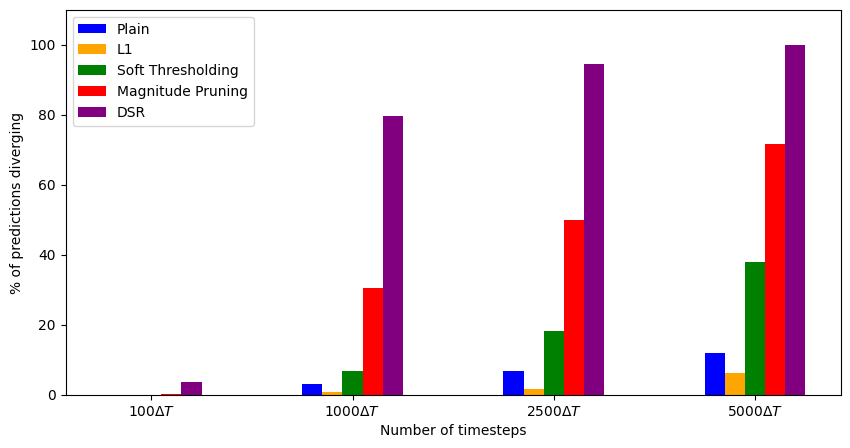

In [ ]:
x_labels = [f"${length} \Delta T$" for length in plot_lengths]
x = [3.5, 8.5, 13.5, 18.5]

colors = ["blue", "orange", "green", "red", "purple"]

plt.use.st

fig, ax= plt.subplots(1, 1, figsize=(10, 5))
for i in range(len(plot_lengths)):
    ax.bar(x[i] - 1, dense_divergence_percentage[i], width=0.5, color=colors[0])
    ax.bar(x[i] - 0.5, L1_divergence_percentage[i], width=0.5, color=colors[1])
    ax.bar(x[i] - 0.0, soft_thershold_divergence_percentage[i], width=0.5, color=colors[2])
    ax.bar(x[i] + 0.5, magnitude_pruning_divergence_percentage[i], width=0.5, color=colors[3])
    ax.bar(x[i] + 1, DSR_divergence_percentage[i], width=0.5, color=colors[4])


ax.set_ylabel("% of predictions diverging")
ax.set_xlabel("Number of timesteps")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylim(0, 110)
ax.legend(["dense", "L1", "Soft Thresholding", "Magnitude Pruning", "DSR"], loc="upper left")

plt.savefig("figures/divergence_detection_normal.pdf", bbox_inches="tight")

## Divergence plot for models regularized with L1

In [ ]:
path = "models/alu/soft_thresholding/l1/model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
L1_soft_thresholding_models = load_models(path, n_models=10)

path = "models/alu/L1_regularization/model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
L1_regularization_models = load_models(path, n_models=10)

path = "models/alu/magnitude_pruning/l1/model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
L1_magnitude_pruning_models = load_models(path, n_models=10)

path = "models/alu/dynamic_sparse_reparameterization/l1/model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
L1_DSR_models = load_models(path, n_models=10)

In [ ]:
test_lengths = [100 * i for i in range(1, 51)]

In [ ]:
models = L1_soft_thresholding_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

L1_soft_threshold_divergence_dict = divergence_dict
L1_soft_threshold_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {L1_soft_threshold_divergence_dict}")

Divergence dictionary for all models: {100: 0, 200: 1, 300: 2, 400: 3, 500: 6, 600: 10, 700: 16, 800: 23, 900: 27, 1000: 34, 1100: 35, 1200: 40, 1300: 45, 1400: 50, 1500: 54, 1600: 58, 1700: 61, 1800: 67, 1900: 69, 2000: 80, 2100: 84, 2200: 88, 2300: 94, 2400: 99, 2500: 110, 2600: 118, 2700: 120, 2800: 123, 2900: 131, 3000: 140, 3100: 144, 3200: 151, 3300: 154, 3400: 158, 3500: 161, 3600: 163, 3700: 166, 3800: 170, 3900: 173, 4000: 175, 4100: 182, 4200: 187, 4300: 189, 4400: 193, 4500: 195, 4600: 196, 4700: 198, 4800: 199, 4900: 204, 5000: 208}


In [ ]:
models = L1_magnitude_pruning_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

L1_magnitude_pruning_divergence_dict = divergence_dict
L1_magnitude_pruning_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {L1_magnitude_pruning_divergence_dict}")

Divergence dictionary for all models: {100: 0, 200: 0, 300: 0, 400: 0, 500: 1, 600: 1, 700: 2, 800: 3, 900: 3, 1000: 3, 1100: 3, 1200: 3, 1300: 6, 1400: 6, 1500: 6, 1600: 6, 1700: 9, 1800: 10, 1900: 11, 2000: 12, 2100: 13, 2200: 15, 2300: 15, 2400: 15, 2500: 15, 2600: 18, 2700: 19, 2800: 20, 2900: 21, 3000: 21, 3100: 25, 3200: 25, 3300: 26, 3400: 26, 3500: 28, 3600: 30, 3700: 32, 3800: 34, 3900: 36, 4000: 38, 4100: 39, 4200: 40, 4300: 42, 4400: 42, 4500: 42, 4600: 42, 4700: 42, 4800: 42, 4900: 42, 5000: 44}


In [ ]:
L1_dynamic_sparse_reparameterization_divergence = []

models = L1_DSR_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

L1_DSR_divergence_dict = divergence_dict
L1_DSR_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {L1_DSR_divergence_dict}")            

Divergence dictionary for all models: {100: 257, 200: 329, 300: 352, 400: 368, 500: 377, 600: 387, 700: 391, 800: 392, 900: 394, 1000: 397, 1100: 399, 1200: 399, 1300: 399, 1400: 399, 1500: 399, 1600: 399, 1700: 399, 1800: 399, 1900: 399, 2000: 399, 2100: 400, 2200: 400, 2300: 400, 2400: 400, 2500: 400, 2600: 400, 2700: 400, 2800: 400, 2900: 400, 3000: 400, 3100: 400, 3200: 400, 3300: 400, 3400: 400, 3500: 400, 3600: 400, 3700: 400, 3800: 400, 3900: 400, 4000: 400, 4100: 400, 4200: 400, 4300: 400, 4400: 400, 4500: 400, 4600: 400, 4700: 400, 4800: 400, 4900: 400, 5000: 400}


In [ ]:
models = L1_regularization_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

L1_divergence_dict = divergence_dict
L1_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {L1_divergence_dict}")  

Divergence dictionary for all models: {100: 0, 200: 0, 300: 1, 400: 1, 500: 2, 600: 2, 700: 2, 800: 2, 900: 2, 1000: 2, 1100: 2, 1200: 2, 1300: 2, 1400: 2, 1500: 2, 1600: 2, 1700: 2, 1800: 2, 1900: 2, 2000: 2, 2100: 2, 2200: 2, 2300: 2, 2400: 2, 2500: 2, 2600: 2, 2700: 2, 2800: 2, 2900: 2, 3000: 2, 3100: 2, 3200: 2, 3300: 2, 3400: 2, 3500: 3, 3600: 5, 3700: 5, 3800: 5, 3900: 5, 4000: 5, 4100: 5, 4200: 5, 4300: 5, 4400: 5, 4500: 5, 4600: 5, 4700: 6, 4800: 6, 4900: 6, 5000: 6}


In [ ]:
results_divergence = {
    "Soft thresholding": L1_soft_threshold_divergence_dict,
    "Magnitude pruning": L1_magnitude_pruning_divergence_dict,
    "DSR": L1_DSR_divergence_dict,
    "L1": L1_divergence_dict,
}

results_RFMSE = {
    "Soft thresholding": L1_soft_threshold_RFMSE_dict,
    "Magnitude pruning": L1_magnitude_pruning_RFMSE_dict,
    "DSR": L1_DSR_RFMSE_dict,
    "L1": L1_RFMSE_dict,
}

with open("results/L1/results_divergence.pickle", "wb") as f:
    pickle.dump(results_divergence, f)

with open("results/L1/results_RFMSE.pickle", "wb") as f:
    pickle.dump(results_RFMSE, f)

In [ ]:
with open("results/L1/results.pickle", "rb") as f:
    results = pickle.load(f)

In [ ]:
plot_lengths = [100, 1000, 2500, 5000]

L1_soft_threshold_divergence_list = [L1_soft_threshold_divergence_dict[length] for length in plot_lengths]
L1_divergence_list = [L1_divergence_dict[length] for length in plot_lengths]
L1_DSR_divergence_list = [L1_DSR_divergence_dict[length] for length in plot_lengths]
L1_magnitude_pruning_divergence_list = [L1_magnitude_pruning_divergence_dict[length] for length in plot_lengths]

In [ ]:
n_tests = len(test_data.data) * len(L1_soft_thresholding_models)

L1_soft_thershold_divergence_percentage = [L1_soft_threshold_divergence / n_tests * 100 for L1_soft_threshold_divergence in L1_soft_threshold_divergence_list]
L1_divergence_percentage = [L1_divergence / n_tests * 100 for L1_divergence in L1_divergence_list]
L1_DSR_divergence_percentage = [L1_DSR_divergence / n_tests * 100 for L1_DSR_divergence in L1_DSR_divergence_list]
L1_magnitude_pruning_divergence_percentage = [L1_magnitude_pruning_divergence / n_tests * 100 for L1_magnitude_pruning_divergence in L1_magnitude_pruning_divergence_list]

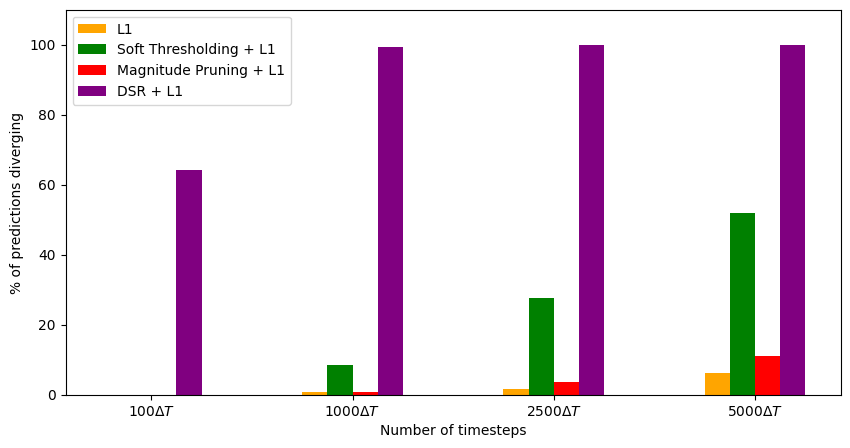

In [ ]:
x_labels = [f"${length} \Delta T$" for length in plot_lengths]
x = [3, 7, 11, 15]

colors = ["orange", "green", "red", "purple"]

fig, ax= plt.subplots(1, 1, figsize=(10, 5))
for i in range(len(plot_lengths)):
    ax.bar(x[i] - 0.75, L1_divergence_percentage[i], width=0.5, color=colors[0])
    ax.bar(x[i] - 0.25, L1_soft_thershold_divergence_percentage[i], width=0.5, color=colors[1])
    ax.bar(x[i] + 0.25, L1_magnitude_pruning_divergence_percentage[i], width=0.5, color=colors[2])
    ax.bar(x[i] + 0.75, L1_DSR_divergence_percentage[i], width=0.5, color=colors[3])
    
ax.set_ylabel("% of predictions diverging")
ax.set_xlabel("Number of timesteps")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylim(0, 110)
ax.legend(["L1", "Soft Thresholding + L1", "Magnitude Pruning + L1", "DSR + L1"], loc="upper left")

plt.savefig("figures/divergence_detection_L1.pdf", bbox_inches="tight")

## Divergence plots for SWA models

In [ ]:
path = "models/alu/L1_regularization/swa_model"
state_dicts = load_state_dicts(path, n_models=10)
layers = [13, 25, 25, 25, 25, 8]
swa_L1_models = []
for state_dict in state_dicts:
    model = torch.optim.swa_utils.AveragedModel(L1RegularizationNet(layers))
    model.load_state_dict(state_dict)
    swa_L1_models.append(model)

path = "models/alu/soft_thresholding/swa_model"
state_dicts = load_state_dicts(path, n_models=10)
layers = [13, 25, 25, 25, 25, 8]
swa_soft_thresholding_models = []
for state_dict in state_dicts:
    model = torch.optim.swa_utils.AveragedModel(SoftThresholdNet(layers, s_init=0))
    model.load_state_dict(state_dict)
    swa_soft_thresholding_models.append(model)

path = "models/alu/dense_net/swa_model"
state_dicts = load_state_dicts(path, n_models=10)
layers = [13, 25, 25, 25, 25, 8]
swa_dense_models = []
for state_dict in state_dicts:
    model = torch.optim.swa_utils.AveragedModel(DenseNet(layers))
    model.load_state_dict(state_dict)
    swa_dense_models.append(model)

path = "models/alu/magnitude_pruning/swa_model"
state_dicts = load_state_dicts(path, n_models=10)
layers = [13, 64, 64, 64, 64, 8]
swa_magnitude_pruning_models = []
for state_dict in state_dicts:
    model = torch.optim.swa_utils.AveragedModel(MagnitudePruningNet(layers))
    model.load_state_dict(state_dict)
    swa_magnitude_pruning_models.append(model)

path = "models/alu/dynamic_sparse_reparameterization/0.1/swa_model"
state_dicts = load_state_dicts(path, n_models=10)
layers = [13, 128, 128, 128, 128, 8]
swa_DSR_models = []
for state_dict in state_dicts:
    model = torch.optim.swa_utils.AveragedModel(DynamicSparseReparameterizationNet(layers, H=0, sparsity=0, Np=0, fractional_tolerence=0))
    model.load_state_dict(state_dict)
    swa_DSR_models.append(model)

/Users/emilhaugstvedt/Desktop/NTNU/master/sparsity/dynamic_sparse_reparameterization/DynamicSparseReparameterizationNet.py:16: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaming_weights = nn.init.kaiming_normal(torch.Tensor(self.weight.shape))


In [ ]:
test_lengths = [100 * i for i in range(1, 51)]

In [ ]:
models = swa_soft_thresholding_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

swa_soft_thershold_divergence_dict = divergence_dict
swa_soft_thershold_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {swa_soft_thershold_divergence_dict}")

Divergence dictionary for all models: {100: 0, 200: 0, 300: 2, 400: 2, 500: 4, 600: 4, 700: 8, 800: 12, 900: 15, 1000: 23, 1100: 28, 1200: 32, 1300: 37, 1400: 42, 1500: 47, 1600: 51, 1700: 58, 1800: 65, 1900: 73, 2000: 75, 2100: 78, 2200: 83, 2300: 84, 2400: 90, 2500: 95, 2600: 98, 2700: 103, 2800: 112, 2900: 119, 3000: 126, 3100: 128, 3200: 132, 3300: 134, 3400: 137, 3500: 142, 3600: 147, 3700: 153, 3800: 160, 3900: 166, 4000: 167, 4100: 170, 4200: 173, 4300: 174, 4400: 179, 4500: 182, 4600: 188, 4700: 192, 4800: 200, 4900: 206, 5000: 209}


In [ ]:
models = swa_L1_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

swa_l1_divergence_dict = divergence_dict
swa_l1_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {swa_l1_divergence_dict}")

Divergence dictionary for all models: {100: 0, 200: 0, 300: 1, 400: 1, 500: 1, 600: 1, 700: 1, 800: 1, 900: 1, 1000: 1, 1100: 2, 1200: 2, 1300: 2, 1400: 2, 1500: 2, 1600: 2, 1700: 2, 1800: 3, 1900: 3, 2000: 4, 2100: 4, 2200: 5, 2300: 5, 2400: 8, 2500: 8, 2600: 8, 2700: 10, 2800: 12, 2900: 12, 3000: 12, 3100: 13, 3200: 14, 3300: 14, 3400: 14, 3500: 15, 3600: 15, 3700: 15, 3800: 15, 3900: 15, 4000: 18, 4100: 19, 4200: 19, 4300: 20, 4400: 20, 4500: 21, 4600: 21, 4700: 23, 4800: 23, 4900: 24, 5000: 25}


In [ ]:
models = swa_DSR_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

swa_DSR_divergence_dict = divergence_dict
swa_DSR_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {swa_DSR_divergence_dict}")

Divergence dictionary for all models: {100: 2, 200: 9, 300: 34, 400: 71, 500: 113, 600: 150, 700: 170, 800: 185, 900: 207, 1000: 218, 1100: 237, 1200: 249, 1300: 258, 1400: 263, 1500: 274, 1600: 282, 1700: 291, 1800: 301, 1900: 308, 2000: 311, 2100: 314, 2200: 318, 2300: 322, 2400: 326, 2500: 328, 2600: 332, 2700: 340, 2800: 344, 2900: 348, 3000: 351, 3100: 354, 3200: 357, 3300: 359, 3400: 360, 3500: 363, 3600: 365, 3700: 367, 3800: 369, 3900: 369, 4000: 370, 4100: 371, 4200: 372, 4300: 374, 4400: 375, 4500: 377, 4600: 377, 4700: 378, 4800: 379, 4900: 381, 5000: 381}


In [ ]:
models = swa_magnitude_pruning_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

swa_magnitude_pruning_divergence_dict = divergence_dict
swa_magnitude_pruning_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {swa_magnitude_pruning_divergence_dict}")

Divergence dictionary for all models: {100: 1, 200: 2, 300: 15, 400: 36, 500: 47, 600: 63, 700: 72, 800: 84, 900: 102, 1000: 110, 1100: 124, 1200: 131, 1300: 137, 1400: 148, 1500: 153, 1600: 160, 1700: 162, 1800: 167, 1900: 171, 2000: 178, 2100: 186, 2200: 195, 2300: 196, 2400: 201, 2500: 211, 2600: 214, 2700: 219, 2800: 222, 2900: 224, 3000: 232, 3100: 234, 3200: 238, 3300: 241, 3400: 243, 3500: 247, 3600: 253, 3700: 259, 3800: 262, 3900: 263, 4000: 267, 4100: 271, 4200: 277, 4300: 280, 4400: 284, 4500: 286, 4600: 289, 4700: 292, 4800: 293, 4900: 299, 5000: 301}


In [ ]:
models = swa_dense_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

swa_dense_divergence_dict = divergence_dict
swa_dense_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {swa_dense_divergence_dict}")

Divergence dictionary for all models: {100: 0, 200: 0, 300: 1, 400: 3, 500: 8, 600: 10, 700: 14, 800: 15, 900: 16, 1000: 17, 1100: 18, 1200: 19, 1300: 19, 1400: 19, 1500: 20, 1600: 20, 1700: 22, 1800: 25, 1900: 26, 2000: 28, 2100: 32, 2200: 33, 2300: 37, 2400: 38, 2500: 39, 2600: 40, 2700: 41, 2800: 42, 2900: 43, 3000: 45, 3100: 46, 3200: 46, 3300: 46, 3400: 47, 3500: 47, 3600: 47, 3700: 49, 3800: 50, 3900: 51, 4000: 54, 4100: 57, 4200: 58, 4300: 58, 4400: 59, 4500: 59, 4600: 60, 4700: 61, 4800: 61, 4900: 61, 5000: 62}


In [ ]:
results_divergence = {
    "Soft thresholding": swa_soft_thershold_divergence_dict,
    "L1": swa_l1_divergence_dict,
    "DSR": swa_DSR_divergence_dict,
    "Magnitude pruning": swa_magnitude_pruning_divergence_dict,
    "dense": swa_dense_divergence_dict,
}

results_RFMSE = {
    "Soft thresholding": swa_soft_thershold_RFMSE_dict,
    "L1": swa_l1_RFMSE_dict,
    "DSR": swa_DSR_RFMSE_dict,
    "Magnitude pruning": swa_magnitude_pruning_RFMSE_dict,
    "dense": swa_dense_RFMSE_dict,
}

with open("results/SWA/results_divergence.pickle", "wb") as f:
    pickle.dump(results_divergence, f)

with open("results/SWA/results_RFMSE.pickle", "wb") as f:
    pickle.dump(results_RFMSE, f)

In [ ]:
with open("results/SWA/results.pickle", "rb") as f:
    results = pickle.load(f)

In [ ]:
plot_lengths = [100, 1000, 2500, 5000]

swa_soft_threshold_divergence_list = [swa_soft_thershold_divergence_dict[length] for length in plot_lengths]
swa_L1_divergence_list = [swa_l1_divergence_dict[length] for length in plot_lengths]
swa_DSR_divergence_list = [swa_DSR_divergence_dict[length] for length in plot_lengths]
swa_magnitude_pruning_divergence_list = [swa_magnitude_pruning_divergence_dict[length] for length in plot_lengths]
swa_dense_divergence_list = [swa_dense_divergence_dict[length] for length in plot_lengths]

In [ ]:
n_tests = len(test_data.data) * len(swa_soft_thresholding_models)

swa_soft_thershold_divergence_percentage = [swa_soft_thershold_divergence / n_tests * 100 for swa_soft_thershold_divergence in swa_soft_threshold_divergence_list]
swa_l1_divergence_percentage = [swa_l1_divergence / n_tests * 100 for swa_l1_divergence in swa_L1_divergence_list]
swa_DSR_divergence_percentage = [swa_DSR_divergence / n_tests * 100 for swa_DSR_divergence in swa_DSR_divergence_list]
swa_magnitude_pruning_divergence_percentage = [swa_magnitude_pruning_divergence / n_tests * 100 for swa_magnitude_pruning_divergence in swa_magnitude_pruning_divergence_list]
swa_dense_divergence_percentage = [swa_dense_divergence / n_tests * 100 for swa_dense_divergence in swa_dense_divergence_list]


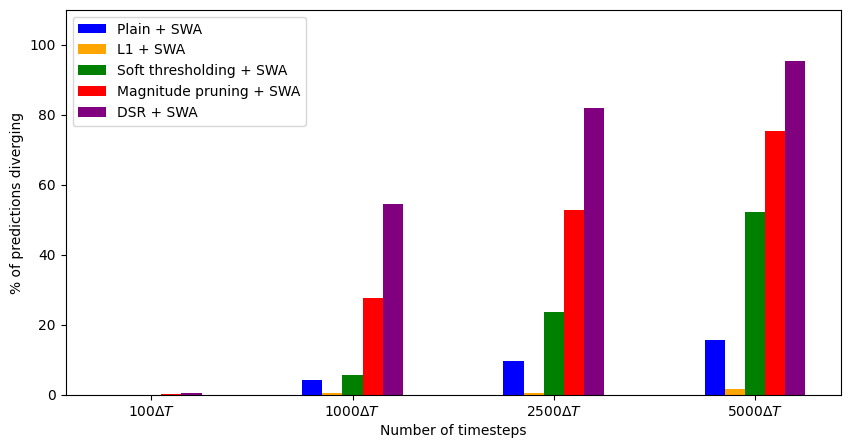

In [ ]:
x_labels = [f"${length} \Delta T$" for length in plot_lengths]
x = [3.5, 8.5, 13.5, 18.5]

colors = ["blue", "orange", "green", "red", "purple"]

fig, ax= plt.subplots(1, 1, figsize=(10, 5))
for i in range(len(plot_lengths)):
    ax.bar(x[i] - 1, swa_dense_divergence_percentage[i], width=0.5, color=colors[0])
    ax.bar(x[i] - 0.5, swa_l1_divergence_percentage[i], width=0.5, color=colors[1])
    ax.bar(x[i] - 0.0, swa_soft_thershold_divergence_percentage[i], width=0.5, color=colors[2])
    ax.bar(x[i] + 0.5, swa_magnitude_pruning_divergence_percentage[i], width=0.5, color=colors[3])
    ax.bar(x[i] + 1, swa_DSR_divergence_percentage[i], width=0.5, color=colors[4])


ax.set_ylabel("% of predictions diverging")
ax.set_xlabel("Number of timesteps")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylim(0, 110)
ax.legend(["dense + SWA", "L1 + SWA", "Soft thresholding + SWA", "Magnitude pruning + SWA", "DSR + SWA"], loc="upper left")

plt.savefig("figures/divergence_detection_swa.pdf", bbox_inches="tight")

## Divergence plot for SWA and L1

In [ ]:
path = "models/alu/L1_regularization/swa_model"
state_dicts = load_state_dicts(path, n_models=10)
layers = [13, 25, 25, 25, 25, 8]
swa_L1_models = []
for state_dict in state_dicts:
    model = torch.optim.swa_utils.AveragedModel(L1RegularizationNet(layers))
    model.load_state_dict(state_dict)
    swa_L1_models.append(model)

path = "models/alu/soft_thresholding/L1/swa_model"
state_dicts = load_state_dicts(path, n_models=10)
layers = [13, 25, 25, 25, 25, 8]
l1_swa_soft_thresholding_models = []
for state_dict in state_dicts:
    model = torch.optim.swa_utils.AveragedModel(SoftThresholdNet(layers, s_init=0))
    model.load_state_dict(state_dict)
    l1_swa_soft_thresholding_models.append(model)

path = "models/alu/magnitude_pruning/L1/swa_model"
state_dicts = load_state_dicts(path, n_models=10)
layers = [13, 64, 64, 64, 64, 8]
l1_swa_magnitude_pruning_models = []
for state_dict in state_dicts:
    model = torch.optim.swa_utils.AveragedModel(MagnitudePruningNet(layers))
    model.load_state_dict(state_dict)
    l1_swa_magnitude_pruning_models.append(model)

path = "models/alu/dynamic_sparse_reparameterization/l1/swa_model"
state_dicts = load_state_dicts(path, n_models=10)
layers = [13, 128, 128, 128, 128, 8]
l1_swa_DSR_models = []
for state_dict in state_dicts:
    model = torch.optim.swa_utils.AveragedModel(DynamicSparseReparameterizationNet(layers, H=0, sparsity=0, Np=0, fractional_tolerence=0))
    model.load_state_dict(state_dict)
    l1_swa_DSR_models.append(model)

/Users/emilhaugstvedt/Desktop/NTNU/master/sparsity/dynamic_sparse_reparameterization/DynamicSparseReparameterizationNet.py:16: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaming_weights = nn.init.kaiming_normal(torch.Tensor(self.weight.shape))


In [ ]:
test_lengths = [100 * i for i in range(1, 51)]

In [ ]:
models = l1_swa_soft_thresholding_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

l1_swa_soft_thershold_divergence_dict = divergence_dict
l1_swa_soft_thershold_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {l1_swa_soft_thershold_divergence_dict}")

Divergence dictionary for all models: {100: 0, 200: 0, 300: 0, 400: 0, 500: 2, 600: 3, 700: 8, 800: 10, 900: 12, 1000: 17, 1100: 19, 1200: 22, 1300: 25, 1400: 32, 1500: 34, 1600: 38, 1700: 44, 1800: 50, 1900: 55, 2000: 58, 2100: 64, 2200: 73, 2300: 81, 2400: 83, 2500: 85, 2600: 87, 2700: 91, 2800: 95, 2900: 97, 3000: 103, 3100: 106, 3200: 108, 3300: 109, 3400: 114, 3500: 123, 3600: 128, 3700: 132, 3800: 134, 3900: 139, 4000: 141, 4100: 145, 4200: 148, 4300: 150, 4400: 156, 4500: 162, 4600: 170, 4700: 173, 4800: 175, 4900: 176, 5000: 178}


In [ ]:
models = swa_L1_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

swa_l1_divergence_dict = divergence_dict
swa_l1_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {swa_l1_divergence_dict}")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/emilhaugstvedt/mambaforge/envs/sparse/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/f5/y5jwy7g16938953ybw9d9kpc0000gn/T/ipykernel_7560/819330547.py", line 5, in <module>
    RFMSE_list, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
  File "/Users/emilhaugstvedt/Desktop/NTNU/master/sparsity/utils.py", line 96, in divergence_detection
  File "/Users/emilhaugstvedt/Desktop/NTNU/master/sparsity/utils.py", line 80, in predict
    x_dot = model(input) * y_std + y_mean
  File "/Users/emilhaugstvedt/mambaforge/envs/sparse/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/Users/emilhaugstvedt/mambaforge/envs/sparse/lib/python3.9/site-packages/torch/optim/swa_utils.py", line 116, in forward
  

In [ ]:
models = l1_swa_DSR_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

l1_swa_DSR_divergence_dict = divergence_dict
l1_swa_DSR_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {l1_swa_DSR_divergence_dict}")

Divergence dictionary for all models: {100: 252, 200: 311, 300: 343, 400: 358, 500: 376, 600: 385, 700: 389, 800: 396, 900: 398, 1000: 399, 1100: 399, 1200: 400, 1300: 400, 1400: 400, 1500: 400, 1600: 400, 1700: 400, 1800: 400, 1900: 400, 2000: 400, 2100: 400, 2200: 400, 2300: 400, 2400: 400, 2500: 400, 2600: 400, 2700: 400, 2800: 400, 2900: 400, 3000: 400, 3100: 400, 3200: 400, 3300: 400, 3400: 400, 3500: 400, 3600: 400, 3700: 400, 3800: 400, 3900: 400, 4000: 400, 4100: 400, 4200: 400, 4300: 400, 4400: 400, 4500: 400, 4600: 400, 4700: 400, 4800: 400, 4900: 400, 5000: 400}


In [ ]:
models = l1_swa_magnitude_pruning_models

divergence_dict = {length: 0 for length in test_lengths}
RFMSE_dict = {length: [] for length in test_lengths}
for model in models:
        model_RFMSE_dict, model_divergence_dict = divergence_detection(model=model, test_data=test_data, test_lengths=test_lengths)
        for length in test_lengths:
            divergence_dict[length] += model_divergence_dict[length]
            RFMSE_dict[length].append(model_RFMSE_dict[length])

l1_swa_magnitude_pruning_divergence_dict = divergence_dict
l1_swa_magnitude_pruning_RFMSE_dict = RFMSE_dict
print(f"Divergence dictionary for all models: {l1_swa_magnitude_pruning_divergence_dict}")

Divergence dictionary for all models: {100: 0, 200: 0, 300: 0, 400: 1, 500: 1, 600: 1, 700: 1, 800: 2, 900: 2, 1000: 2, 1100: 2, 1200: 3, 1300: 4, 1400: 4, 1500: 6, 1600: 9, 1700: 9, 1800: 10, 1900: 10, 2000: 11, 2100: 13, 2200: 14, 2300: 16, 2400: 16, 2500: 16, 2600: 16, 2700: 17, 2800: 17, 2900: 21, 3000: 22, 3100: 23, 3200: 23, 3300: 25, 3400: 25, 3500: 26, 3600: 28, 3700: 31, 3800: 33, 3900: 34, 4000: 36, 4100: 39, 4200: 39, 4300: 40, 4400: 42, 4500: 45, 4600: 45, 4700: 46, 4800: 48, 4900: 52, 5000: 54}


In [ ]:
results_divergence = {
    "Soft thresholding": l1_swa_soft_thershold_divergence_dict,
    "L1": swa_l1_divergence_dict,
    "DSR": l1_swa_DSR_divergence_dict,
    "Magnitude pruning": l1_swa_magnitude_pruning_divergence_dict,
}

results_RFMSE = {
    "Soft thresholding": l1_swa_soft_thershold_RFMSE_dict,
    "L1": swa_l1_RFMSE_dict,
    "DSR": l1_swa_DSR_RFMSE_dict,
    "Magnitude pruning": l1_swa_magnitude_pruning_RFMSE_dict,
}

with open("results/SWA + L1/results_divergence.pickle", "wb") as f:
    pickle.dump(results_divergence, f)

with open("results/SWA + L1/results_RFMSE.pickle", "wb") as f:
    pickle.dump(results_RFMSE, f)

In [ ]:
with open("results/SWA + L1/results.pickle", "rb") as f:
    results = pickle.load(f)

In [ ]:
plot_lengths = [100, 1000, 2500, 5000]

swa_L1_soft_threshold_divergence_list = [swa_soft_thershold_divergence_dict[length] for length in plot_lengths]
swa_L1_divergence_list = [swa_l1_divergence_dict[length] for length in plot_lengths]
swa_L1_DSR_divergence_list = [swa_DSR_divergence_dict[length] for length in plot_lengths]
swa_L1_magnitude_pruning_divergence_list = [swa_magnitude_pruning_divergence_dict[length] for length in plot_lengths]

In [ ]:
n_tests = len(test_data.data) * len(swa_soft_thresholding_models)

l1_swa_soft_thershold_divergence_percentage = [l1_swa_soft_thershold_divergence / n_tests * 100 for l1_swa_soft_thershold_divergence in swa_L1_soft_threshold_divergence_list]
l1_swa_divergence_percentage = [l1_swa_divergence / n_tests * 100 for l1_swa_divergence in swa_L1_divergence_list]
l1_swa_DSR_divergence_percentage = [l1_swa_DSR_divergence / n_tests * 100 for l1_swa_DSR_divergence in swa_L1_DSR_divergence_list]
l1_swa_magnitude_pruning_divergence_percentage = [l1_swa_magnitude_pruning_divergence / n_tests * 100 for l1_swa_magnitude_pruning_divergence in swa_L1_magnitude_pruning_divergence_list]


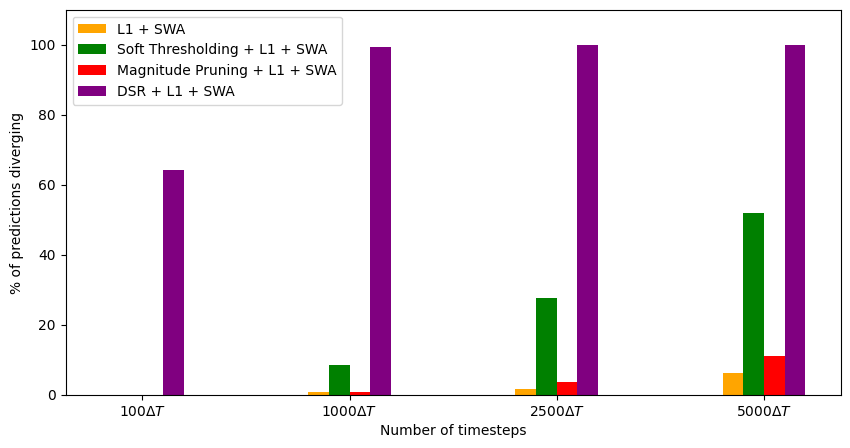

In [ ]:
x_labels = [f"${length} \Delta T$" for length in plot_lengths]
x = [3.5, 8.5, 13.5, 18.5]

colors = ["orange", "green", "red", "purple"]

fig, ax= plt.subplots(1, 1, figsize=(10, 5))
for i in range(len(plot_lengths)):
    ax.bar(x[i] - 0.75, L1_divergence_percentage[i], width=0.5, color=colors[0])
    ax.bar(x[i] - 0.25, L1_soft_thershold_divergence_percentage[i], width=0.5, color=colors[1])
    ax.bar(x[i] + 0.25, L1_magnitude_pruning_divergence_percentage[i], width=0.5, color=colors[2])
    ax.bar(x[i] + 0.75, L1_DSR_divergence_percentage[i], width=0.5, color=colors[3])


ax.set_ylabel("% of predictions diverging")
ax.set_xlabel("Number of timesteps")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylim(0, 110)
ax.legend(["L1 + SWA", "Soft Thresholding + L1 + SWA", "Magnitude Pruning + L1 + SWA", "DSR + L1 + SWA"], loc="upper left")

plt.savefig("figures/divergence_detection_l1_swa.pdf", bbox_inches="tight")

# Compairsion for different models using different techniques

In [ ]:
with open("results/normal/results.pickle", "rb") as f:
    normal_results = pickle.load(f)

with open("results/L1/results.pickle", "rb") as f:
    L1_results = pickle.load(f)

with open("results/SWA/results.pickle", "rb") as f:
    swa_results = pickle.load(f)

with open("results/SWA + L1/results.pickle", "rb") as f:
    L1_SWA_results = pickle.load(f)

In [ ]:
model_type = "L1"

nomal_divergence = normal_results[model_type]
L1_divergence = L1_results[model_type]
SWA_divergence = swa_results[model_type]
L1_SWA_divergence = L1_SWA_results[model_type]

In [ ]:
plot_lengths = [100, 1000, 2500, 5000]

normal_divergence_list= [nomal_divergence[length] for length in plot_lengths]
L1_divergence_list = [L1_divergence[length] for length in plot_lengths]
SWA_divergence_list = [SWA_divergence[length] for length in plot_lengths]
L1_SWA_divergence_list = [L1_SWA_divergence[length] for length in plot_lengths]

In [ ]:
n_tests = len(test_data.data) * len(swa_soft_thresholding_models)

normal_divergence_percentage = [normal_divergence / n_tests * 100 for normal_divergence in normal_divergence_list]
L1_divergence_percentage = [L1_divergence / n_tests * 100 for L1_divergence in L1_divergence_list]
SWA_divergence_percentage = [SWA_divergence / n_tests * 100 for SWA_divergence in SWA_divergence_list]
L1_SWA_divergence_percentage = [L1_SWA_divergence / n_tests * 100 for L1_SWA_divergence in L1_SWA_divergence_list]

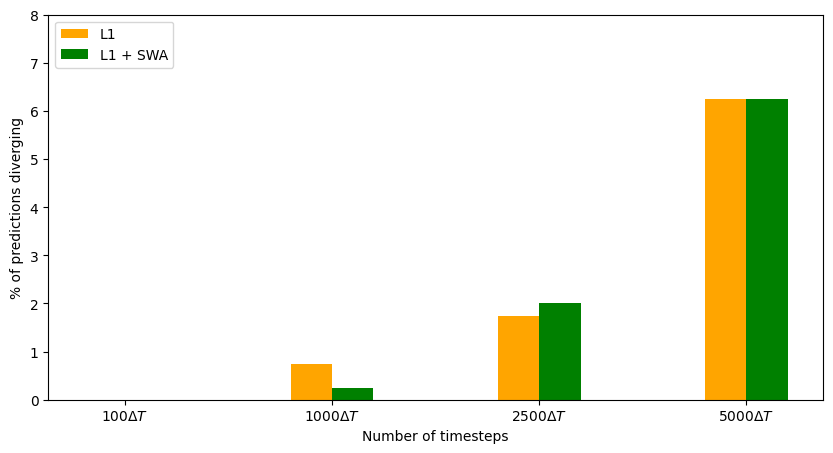

In [ ]:
x_labels = [f"${length} \Delta T$" for length in plot_lengths]
x = [3.5, 8.5, 13.5, 18.5]

colors = ["blue", "orange", "green", "red", "purple"]

fig, ax= plt.subplots(1, 1, figsize=(10, 5))
for i in range(len(plot_lengths)):
    ax.bar(x[i] - 0.75, normal_divergence_percentage[i], width=0.5, color=colors[0])
    ax.bar(x[i] - 0.25, L1_divergence_percentage[i], width=0.5, color=colors[1])
    ax.bar(x[i] + 0.25, SWA_divergence_percentage[i], width=0.5, color=colors[2])
    ax.bar(x[i] + 0.75, L1_SWA_divergence_percentage[i], width=0.5, color=colors[3])

ax.set_ylabel("% of predictions diverging")
ax.set_xlabel("Number of timesteps")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylim(0, 110)
ax.legend(["dense", "L1", "SWA", "SWA + L1"], loc="upper left")

plt.savefig(f"figures/{model_type}/divergence_detection.pdf", bbox_inches="tight")

/var/folders/f5/y5jwy7g16938953ybw9d9kpc0000gn/T/ipykernel_10224/1134721484.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


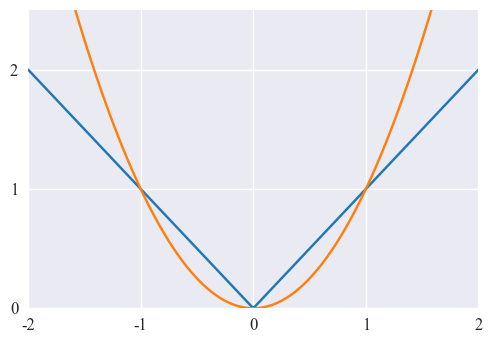

In [74]:

plt.style.use("seaborn")

fig, ax = plt.subplots(1, 1, figsize=set_size(600, 0.7))
x = torch.linspace(-2, 2, 1000)
l1 = torch.abs(x)
l2 = torch.abs(x) ** 2

x_tick = [-2, -1, 0, 1, 2]
y_tick = [0, 1, 2]

font_size = 12

colors = ["#1f77b4", "#ff7f0e"]

ax.plot(x, l1, label="l1", color=colors[0])
ax.plot(x, l2, label="l2", color=colors[1])
ax.set_xticks(x_tick)
ax.set_yticks(y_tick)
ax.set_xticklabels([f"{int(y)}" for y in ax.get_xticks()], fontsize=12, **csfont)
ax.set_yticklabels([f"{int(x)}" for x in ax.get_yticks()], fontsize=12, **csfont)
ax.set_ylim(0, 2.5)
ax.set_xlim(-2, 2)

plt.savefig("figures/L1_vs_L2.pdf", bbox_inches="tight")

In [105]:
# Load dense models:
path = "models/alu/soft_thresholding/swa_model" # dense, soft_thresholding, L1-regularization, dynamic_sparse_reparameterization, magnitude_pruning
dicts = load_models(path, n_models=10)
models = []
for dict in dicts:
    model = torch.optim.swa_utils.AveragedModel(SoftThresholdNet(layers=[13, 25, 25, 25, 25, 8], s_init=1))
    model.load_state_dict(dict)
    models.append(model)

sum([model.get_sparsity() for model in models]) / len(models)

AttributeError: 'AveragedModel' object has no attribute 'get_sparsity'